In [66]:
# Env Setup
!pip install tensorflow tensorflow_io librosa numpy matplotlib


In [67]:
# ---- Imports ----
import os, random, math
from pathlib import Path
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf


In [68]:
# -------------------------------------------------------
# Audio Parameters
# -------------------------------------------------------
SAMPLE_RATE = 8000
WINDOW_SIZE = 0.025
FFT_SIZE = int(SAMPLE_RATE * WINDOW_SIZE)   # 200
HOP_SIZE = int(0.010 * SAMPLE_RATE)         # 80
N_MFCC = 32
MAX_DURATION = 2.0
EXPECTED_SAMPLES = int(SAMPLE_RATE * MAX_DURATION)  # 16000
FIXED_FRAMES = 80  #

print("Sample rate:", SAMPLE_RATE)
print("FFT Size:", FFT_SIZE)
print("HOP_SIZE:", HOP_SIZE)

Sample rate: 8000
FFT Size: 200
HOP_SIZE: 80


In [69]:
# ---- Load file paths and labels from your folder structure: datasets/<label>/*.wav ----
lang = "es"
data_path = "../dataset"
data_root = Path(data_path + "/" + lang)   
if not data_root.exists():
    raise RuntimeError(f"datasets folder not found at {data_root.resolve()}")

label_names = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
if len(label_names) == 0:
    raise RuntimeError("No label directories found under 'datasets' (expect datasets/<label>/*.wav)")

label_to_idx = {n:i for i,n in enumerate(label_names)}

files = []
labels = []
for label in label_names:
    for f in sorted((data_root/label).glob("*.wav")):
        files.append(str(f))
        labels.append(label_to_idx[label])

if len(files) == 0:
    raise RuntimeError("No .wav files found in datasets. Check paths and file extensions.")

print("Labels:", label_names)
print("Total files:", len(files))


Labels: ['backward', 'forward', 'left', 'right']
Total files: 40


In [70]:
# ---- Shuffle deterministically (buffer size uses dataset length) ----
pairs = list(zip(files, labels))
random.shuffle(pairs)
files, labels = zip(*pairs)
files = list(files); labels = list(labels)
n_total = len(files)
n_train = int(n_total * 0.8)
print("Total files:", n_total, "Train:", n_train, "Val:", n_total - n_train)

Total files: 40 Train: 32 Val: 8


In [127]:
# ---- AUDIO PREPROCESSING HELPERS ----
# ---- MFCC extraction helper (librosa) ----
def extract_mfcc(path):
    """
    Load an audio file, trim leading/trailing silence, normalize amplitude,
    pad/truncate to EXPECTED_SAMPLES, and compute MFCCs.
    Returns: np.float32 array of shape (frames, N_MFCC)
    """
    # load audio
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)

    # normalize volume to max amplitude = 1
    if y.size > 0:
        y = y / (np.max(np.abs(y)) + 1e-9)

     # trim leading/trailing silence
    y, _ = librosa.effects.trim(y, top_db=20)

    # pad or truncate to expected length (2 seconds)
    if len(y) > EXPECTED_SAMPLES:
        y = y[:EXPECTED_SAMPLES]
    else:
        pad_len = EXPECTED_SAMPLES - len(y)
        if pad_len > 0:
            y = np.pad(y, (0, pad_len), mode='constant')

    # MFCC parameters
    hop_length = HOP_SIZE
    n_fft = FFT_SIZE

    # compute MFCC (returns shape n_mfcc x t)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=n_fft, hop_length=hop_length)

    # transpose to (frames, n_mfcc)
    mfcc = mfcc.T.astype(np.float32)
    return mfcc

# ---- fix_length: pad or truncate frames to FIXED_FRAMES ----
def fix_length(mfcc, max_frames=FIXED_FRAMES):
    """
    Pad or truncate MFCC frames to fixed length.
    mfcc: (frames, N_MFCC)
    """
    if mfcc.shape[0] >= max_frames:
        return mfcc[:max_frames, :]
    else:
        pad_rows = max_frames - mfcc.shape[0]
        return np.vstack([mfcc, np.zeros((pad_rows, mfcc.shape[1]), dtype=np.float32)])

In [128]:
# Quick check (if you have at least one file)
mf = extract_mfcc(files[0])
print("Example MFCC shape (frames, n_mfcc):", mf.shape)   # e.g. (161, 32)
mf_fixed = fix_length(mf)
print("After fix_length:", mf_fixed.shape)

Example MFCC shape (frames, n_mfcc): (201, 32)
After fix_length: (80, 32)


In [129]:
# ---- The Python function called from tf.data (must accept a tensor, return numpy) ----
def _py_extract(path_tensor):
    """
    This function will be called inside tf.py_function.
    path_tensor is a tf.Tensor of dtype string; we convert to Python str, process,
    and return a numpy array of shape (FIXED_FRAMES, N_MFCC) dtype float32.
    """
    try:
        path = path_tensor.numpy().decode('utf-8') if isinstance(path_tensor, (bytes, bytearray)) or hasattr(path_tensor, "numpy") else str(path_tensor)
        mf = extract_mfcc(path)
        mf = fix_length(mf, max_frames=FIXED_FRAMES)
        return mf
    except Exception as e:
        # On error, return zeros so tf pipeline doesn't crash (but you should inspect logs)
        print(f"Error processing {path_tensor!r}: {e}")
        return np.zeros((FIXED_FRAMES, N_MFCC), dtype=np.float32)

# ---- tf.data pipeline using from_tensor_slices + tf.py_function (fixed) ----
# Create TensorFlow tensors for file paths and labels
files_tf = tf.constant(files, dtype=tf.string)
labels_tf = tf.constant(labels, dtype=tf.int32)

def load_and_preprocess(path, label):
    """
    TF wrapper: apply extract_mfcc + fix_length inside tf.py_function
    Returns tensor of shape (FIXED_FRAMES, N_MFCC, 1) and label
    """
    def _extract_and_fix(p):
        mf = extract_mfcc(p.decode('utf-8'))  # path is a tf.string
        # Pad/truncate frames to FIXED_FRAMES
        if mf.shape[0] >= FIXED_FRAMES:
            mf_fixed = mf[:FIXED_FRAMES, :]
        else:
            pad_rows = FIXED_FRAMES - mf.shape[0]
            mf_fixed = np.vstack([mf, np.zeros((pad_rows, mf.shape[1]), dtype=np.float32)])
        return mf_fixed

    mf = tf.py_function(func=_extract_and_fix, inp=[path], Tout=tf.float32)
    mf.set_shape((FIXED_FRAMES, N_MFCC))       # tell TF shape for autographs
    mf = tf.expand_dims(mf, -1)               # (frames, n_mfcc, 1)
    return mf, label

In [130]:
# Build dataset
ds_all = tf.data.Dataset.from_tensor_slices((files_tf, labels_tf))
# shuffle buffer = n_total (not 1000)
ds_all = ds_all.shuffle(buffer_size=n_total, reshuffle_each_iteration=True)
# map (calls the Python MFCC extractor)
ds_all = ds_all.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# split into train / val using take/skip after shuffle
train_ds = ds_all.take(n_train).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_all.skip(n_train).batch(32).prefetch(tf.data.AUTOTUNE)

print("Train batches (approx):", sum(1 for _ in train_ds))
print("Val batches (approx):", sum(1 for _ in val_ds))

Train batches (approx): 1
Val batches (approx): 1


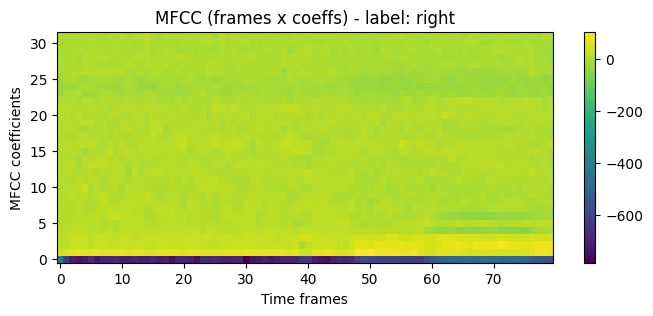

In [131]:
# ---- Example: plot one MFCC (from dataset) ----
for x_batch, y_batch in ds_all.take(1):
    # x_batch shape (FIXED_FRAMES, N_MFCC, 1)
    mf = x_batch.numpy()
    lab = int(y_batch.numpy())
    mf = np.squeeze(mf)  # (FIXED_FRAMES, N_MFCC)
    plt.figure(figsize=(8,3))
    plt.imshow(mf.T, origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"MFCC (frames x coeffs) - label: {label_names[lab]}")
    plt.xlabel("Time frames")
    plt.ylabel("MFCC coefficients")
    plt.show()
    break

In [132]:
# ---- Minimal model (same architecture you used) ----
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(FIXED_FRAMES, N_MFCC, 1)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.DepthwiseConv2D((3,3), padding='same', activation='relu'),
    layers.Conv2D(24, (3,3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(label_names), activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 80, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_15             │ (None, 80, 32, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 80, 32, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 24)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,732 (18.48 KB)

 Trainable params: 4,732 (18.48 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# ---- Train ----
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step - accuracy: 0.2188 - loss: 1.4122 - val_accuracy: 0.5000 - val_loss: 1.3219
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2500 - loss: 1.3834 - val_accuracy: 0.2500 - val_loss: 1.3888
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2188 - loss: 1.4069 - val_accuracy: 0.3750 - val_loss: 1.3757
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2188 - loss: 1.3915 - val_accuracy: 0.3750 - val_loss: 1.3745
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2500 - loss: 1.3911 - val_accuracy: 0.1250 - val_loss: 1.3684
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2500 - loss: 1.3907 - val_accuracy: 0.5000 - val_loss: 1.3379
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2500 - loss: 1.3909 - val_accuracy: 0.1250 - val_loss: 1.4056
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2500 - loss: 1.3896 - val_accuracy: 0.1250 - val_loss: